# Research Skills: Spatiotemporal Data Analyis
## Take-home Assignment
Sharon Ong, Department of Cognitive Science and Artificial Intelligence,
Tilburg University
Academic Year 2024-2025

Your First Name: Lorenzo 

Your Last Name: Montin

Your Student ID: 2148497

In [1]:
import numpy as np
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import pandas as pd
from sktime.transformations.series.detrend import STLTransformer
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sktime.split import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.base import ForecastingHorizon

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, cross_val_score



In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Part 1A
## Time series analysis and forecasting of patient arrivals in an 
emergency department

1. [5 points] Load the dataset. Display the temporal autocorelation and partial autocorrelation in a plot.
Points breakdown: 3 points for displaying the autocorrelation. 2 points for loading the dataset.

,Date,Arrivals
0,2014-01-01,90
1,2014-01-02,97
2,2014-01-03,80
3,2014-01-04,92
4,2014-01-05,76
...,...,...
1395,2017-10-27,108
1396,2017-10-28,108
1397,2017-10-29,113
1398,2017-10-30,124


Text(0.5, 1.0, 'Partial autocorrelation of daily ED arrivals')

<Figure size 1200x800 with 0 Axes>

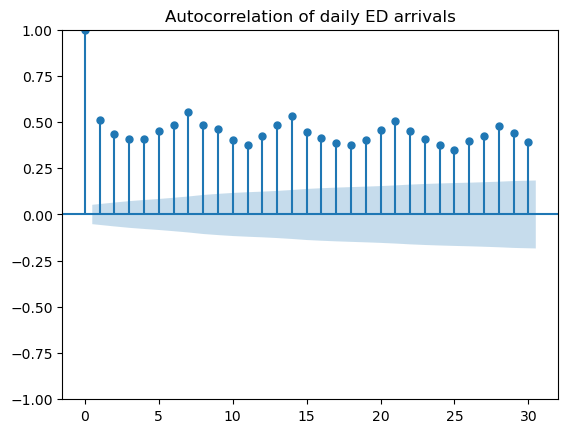

<Figure size 1200x800 with 0 Axes>

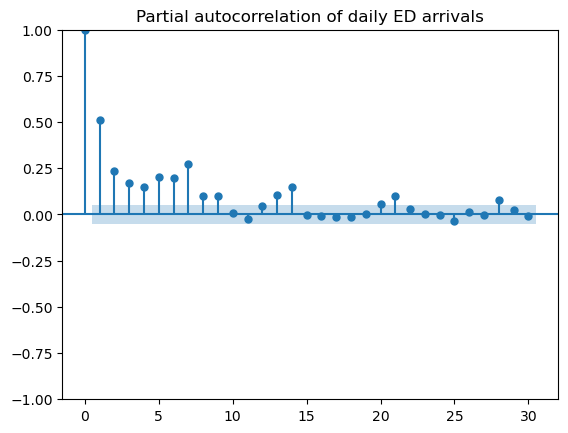

In [5]:
#
# Your code goes here 
#
df = pd.read_csv('ed_time_series.csv')
display(df)


plt.figure(figsize=(12,8))
plot_acf(df["Arrivals"], lags = 30)
plt.title("Autocorrelation of daily ED arrivals")

plt.figure(figsize=(12,8))
plot_pacf(df["Arrivals"], lags= 30)
plt.title("Partial autocorrelation of daily ED arrivals")

2. [10 points] Separate the trend, seasonal and residual noise components. Try three different periodicity
inputs; 7 days, 30 days and 365 days. Display each component separately for each periodicity. For eac .decompsition for given the periodicty, display the residual noise as a scatter plot as well as the temporal
autocorrelation and partial autocorrelation of the residual noise. Are there are cyclic, trend or seasonalff
e
ects which are unaccounted for each periodicity value? From your interpretation of the residual plots
and components, which of the three periodicity values is preferred?
Points breakdown: 3 points for separating the trend, 2 points for displaying each component. 3 points
for the scatter plot, histogram plot of the residuals and 2 points for your inteprertion..

C:\Users\monti\AppData\Local\Temp\ipykernel_34384\1593975065.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


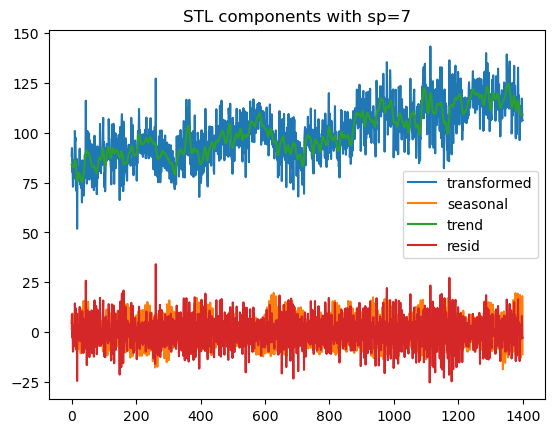

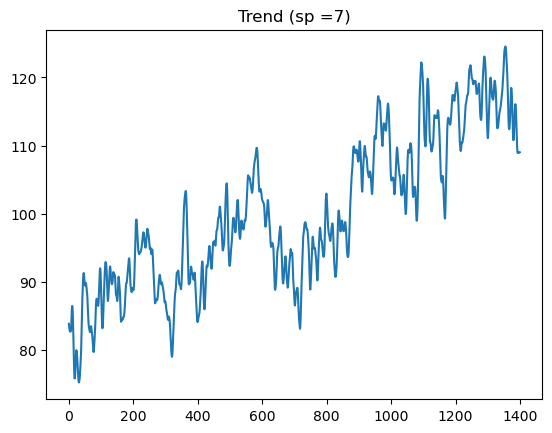

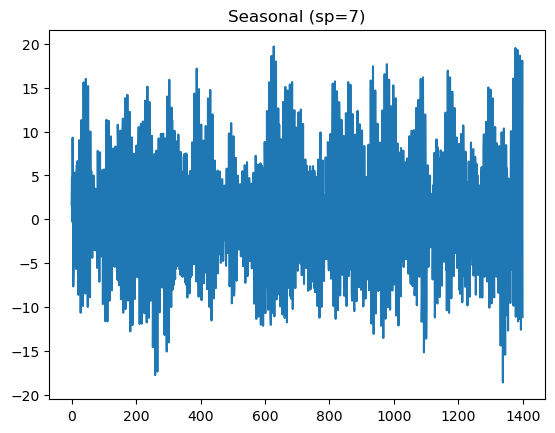

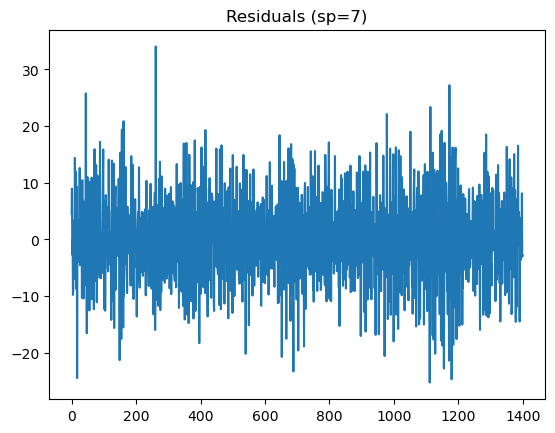

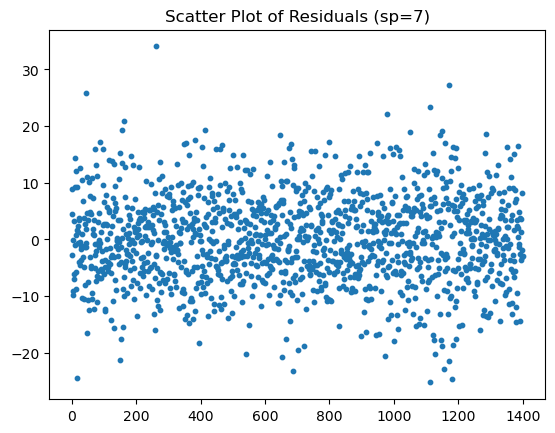

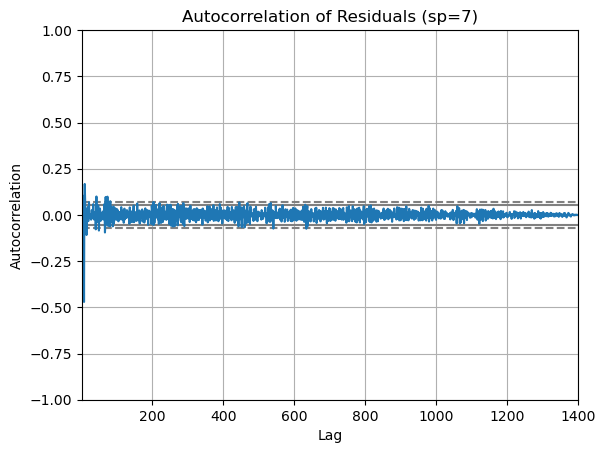

<Figure size 640x480 with 0 Axes>

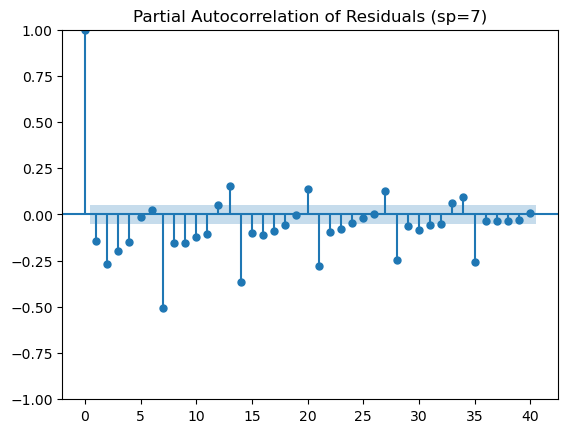

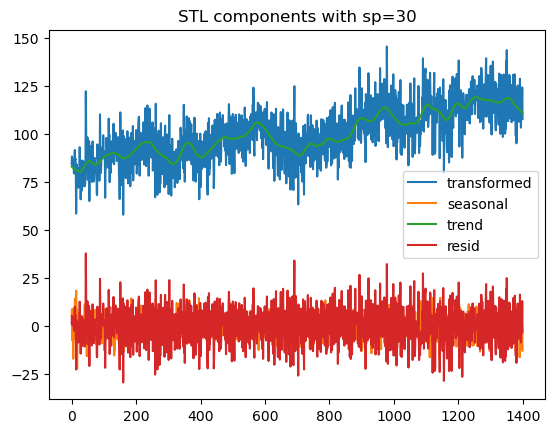

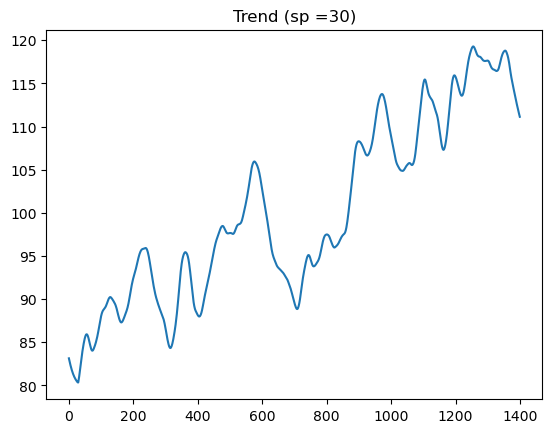

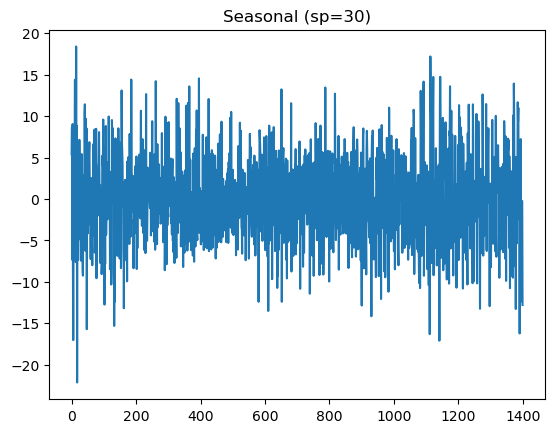

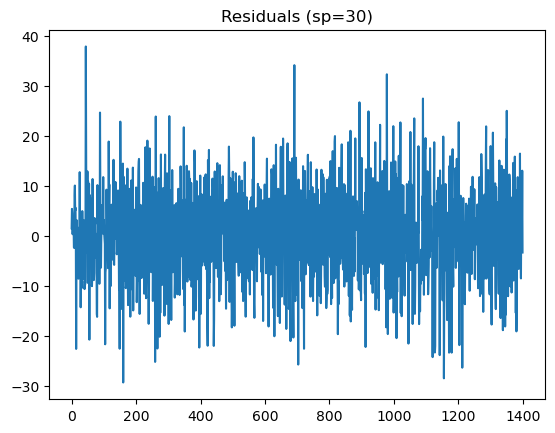

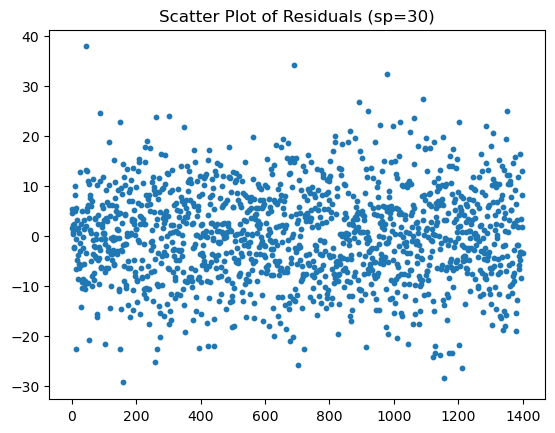

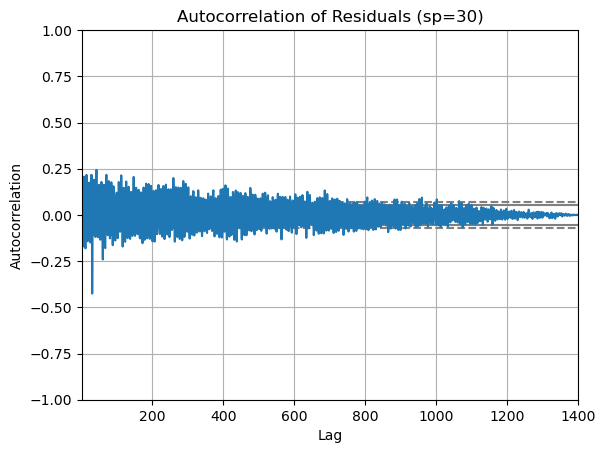

<Figure size 640x480 with 0 Axes>

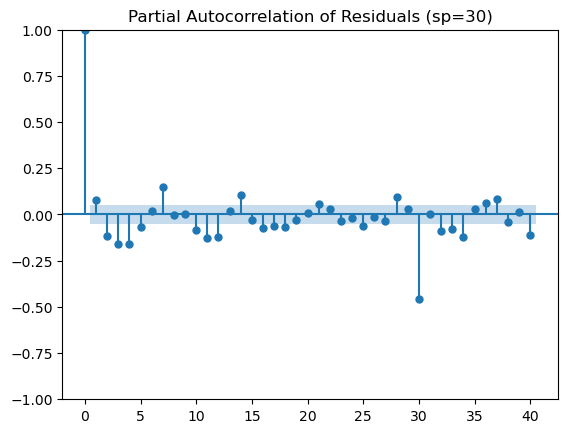

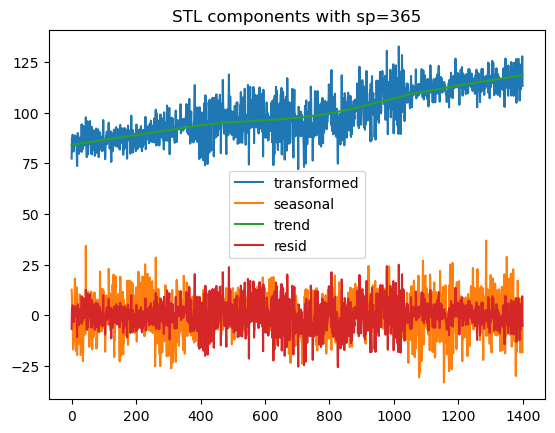

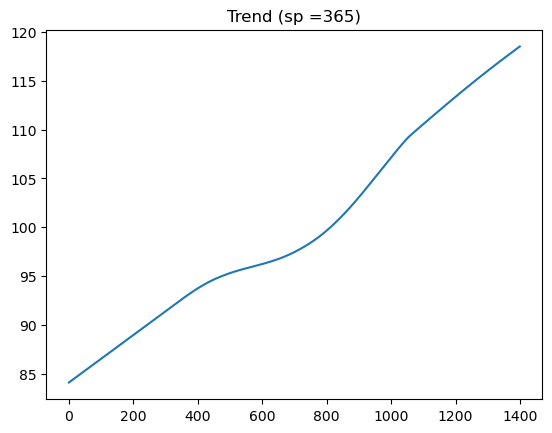

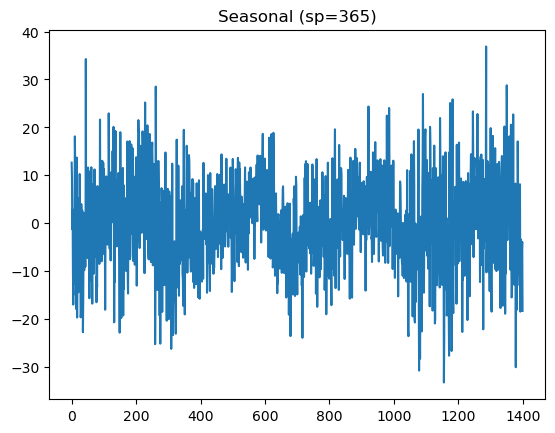

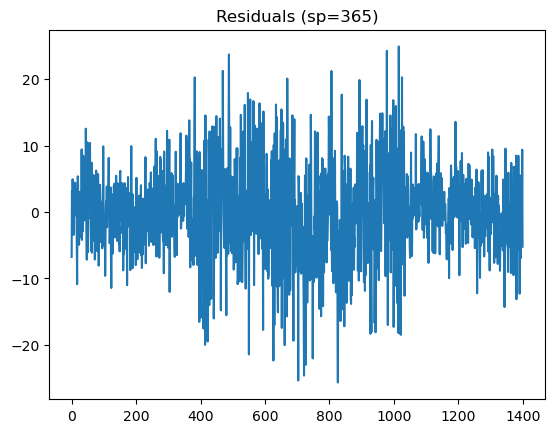

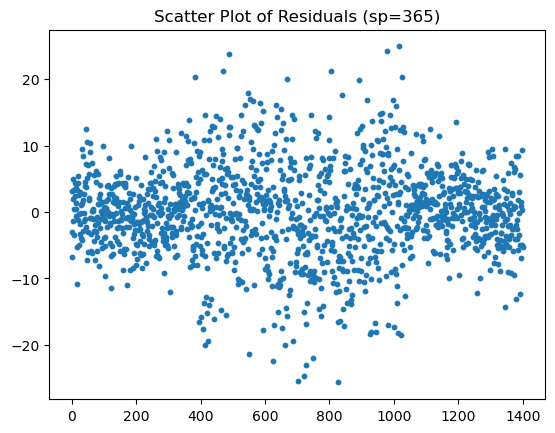

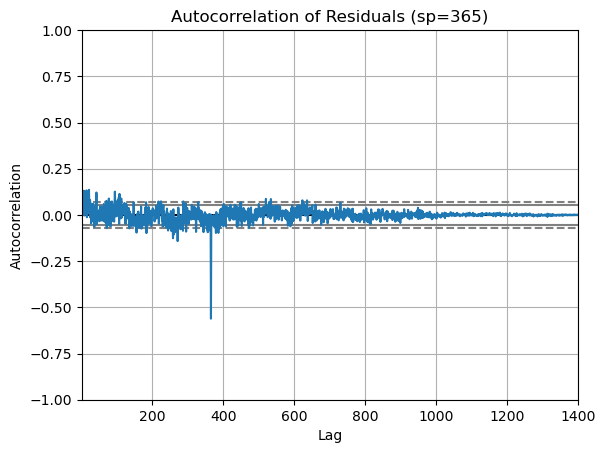

<Figure size 640x480 with 0 Axes>

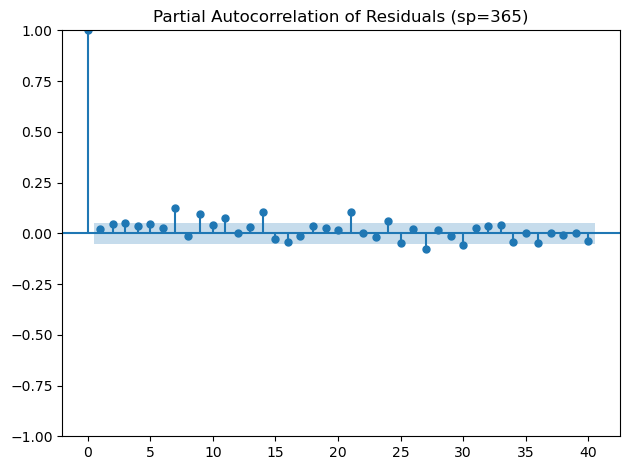

In [7]:
#
# Your code goes here 
#
periods = [7,30,365]

for sp in periods:
    transformer = STLTransformer(sp = sp, return_components= True)
    result = transformer.fit_transform(df["Arrivals"])

    result.plot()
    plt.title(f"STL components with sp={sp}")
    
    plt.figure()
    plt.plot(result.trend)
    plt.title(f"Trend (sp ={sp})")

    plt.figure()
    plt.plot(result.seasonal)
    plt.title(f"Seasonal (sp={sp})")
    
    plt.figure()
    plt.plot(result.resid)
    plt.title(f"Residuals (sp={sp})")

    plt.figure()
    plt.scatter(result.index, result.resid, s=10)
    plt.title(f"Scatter Plot of Residuals (sp={sp})")

    plt.figure()
    autocorrelation_plot(result.resid)
    plt.title(f"Autocorrelation of Residuals (sp={sp})")

    plt.figure()
    plot_pacf(result.resid.dropna(), lags=40) #here lags should be at least 365
    plt.title(f"Partial Autocorrelation of Residuals (sp={sp})")

plt.tight_layout()
plt.show()


Your answer goes here.
For sp = 7, the STL decomposition captures a clear upward trend and a weekly seasonal pattern. However, the residuals show notable peaks and exhibit some autocorrelation, indicating that short-term irregular patterns or additional cyclic effects remain unaccounted for.
With sp = 30, the STL decomposition extracts again a clear upward trend and a smooth monthly seasonal pattern. However, the residuals indicate unmodeled weekly seasonality, as seen in the autocorrelation plot with significant spikes at low lags. The scatter plot appears random, but the residuals are not white noise due to remaining structure. This suggests that a 30-day cycle does not fully capture the underlying seasonal dynamics of the data.
With sp = 365, the STL decomposition  captures both the ascending trend and annual seasonal patterns. The residuals show a tight distribution around zero in the scatter plot, and the autocorrelation plot shows only a single negative spike.



    



3. [5 points] This question is on time series forecasting with Exponential Smoothing. Begin by spliting the
time series into train and test sets. Fit an exponential smoothing model on the dataset. Evaluate your
forecasting accuracy on two ffi
erennt forecasting horizons (7 days and 30 days) by computing
the mean absolute percentage error. Plot the train, test set and your predicted solution. Label
your plot.

MAPE (7)- day forecast): 8.27%
MAPE (30)- day forecast): 11.63%


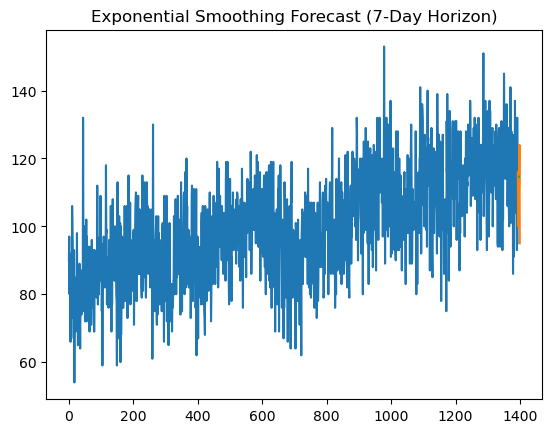

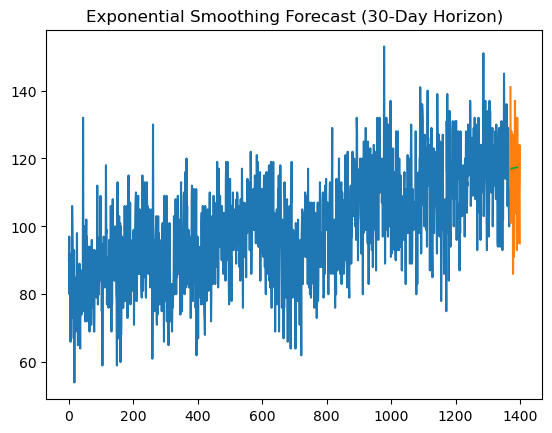

In [9]:
#
# Your code goes here 
#

series = df["Arrivals"]
forecast_horizons = [7,30]

for horizon in forecast_horizons:
    y_train = series[:-horizon]
    y_test = series[-horizon:]

    fh = ForecastingHorizon(y_test.index, is_relative = False) #isrelative useful when having timestamps, the model aligns predicitions with exact dates
    model = ExponentialSmoothing(trend ="add", seasonal=None , sp = 1 )
    model.fit(y_train)

    y_pred =  model.predict(fh)

    mape = mean_absolute_percentage_error(y_test,y_pred)
    print(f"MAPE ({horizon})- day forecast): {mape:.2%}")

    plt.figure()
    plt.plot(y_train, label = "Train")
    plt.plot(y_test, label = "Test")
    plt.plot(y_pred, label = "Forecast", linestyle= "--")
    plt.title(f"Exponential Smoothing Forecast ({horizon}-Day Horizon)")

    

4. [15 points]  This question is on time series forecasting with ARIMA* Split the time series into a train, validation and test set. (2 points) * Fit an ARIMA or SARIMA model on the training set. Find the optimal p,d and q values fo  
ARIMA (by evaluating the mean absolute percentage error on the validation set). Choose the least different values for p and 2 different values for d and q. (6 point*)  With the best p,d and q values you fofind, t an ARIMA model on the combined train and validation set. Evaluate your model on two di erent forecasting horizons (7 days or 30 days) using the mean absolute percentage error.(6 po*nts)
 Display the train, validation, test set and your predicted solution. Label your plot. (1 point)
Note that as we have to different forecasting horizons, you may chose to creatff two dierent train and
test sets; one for a 7 day forecast and one for a 30 day  (1 point)

Tested model with (p=0, d=0, q=0) => MAPE: 12.33%


C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested model with (p=0, d=0, q=1) => MAPE: 12.83%


C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested model with (p=0, d=0, q=2) => MAPE: 12.59%
Tested model with (p=0, d=1, q=0) => MAPE: 12.88%
Tested model with (p=0, d=1, q=1) => MAPE: 12.01%
Tested model with (p=0, d=1, q=2) => MAPE: 12.21%
Tested model with (p=1, d=0, q=0) => MAPE: 12.87%


C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested model with (p=1, d=0, q=1) => MAPE: 12.15%
Tested model with (p=1, d=0, q=2) => MAPE: 12.23%
Tested model with (p=1, d=1, q=0) => MAPE: 12.56%
Tested model with (p=1, d=1, q=1) => MAPE: 12.16%
Tested model with (p=1, d=1, q=2) => MAPE: 12.03%
Tested model with (p=2, d=0, q=0) => MAPE: 12.72%
Tested model with (p=2, d=0, q=1) => MAPE: 12.33%
Tested model with (p=2, d=0, q=2) => MAPE: 12.10%
Tested model with (p=2, d=1, q=0) => MAPE: 12.33%
Tested model with (p=2, d=1, q=1) => MAPE: 11.93%


C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tested model with (p=2, d=1, q=2) => MAPE: 12.12%
Best model parameters: (p=2, d=1, q=1)
Best MAPE: 11.93%


C:\Users\monti\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


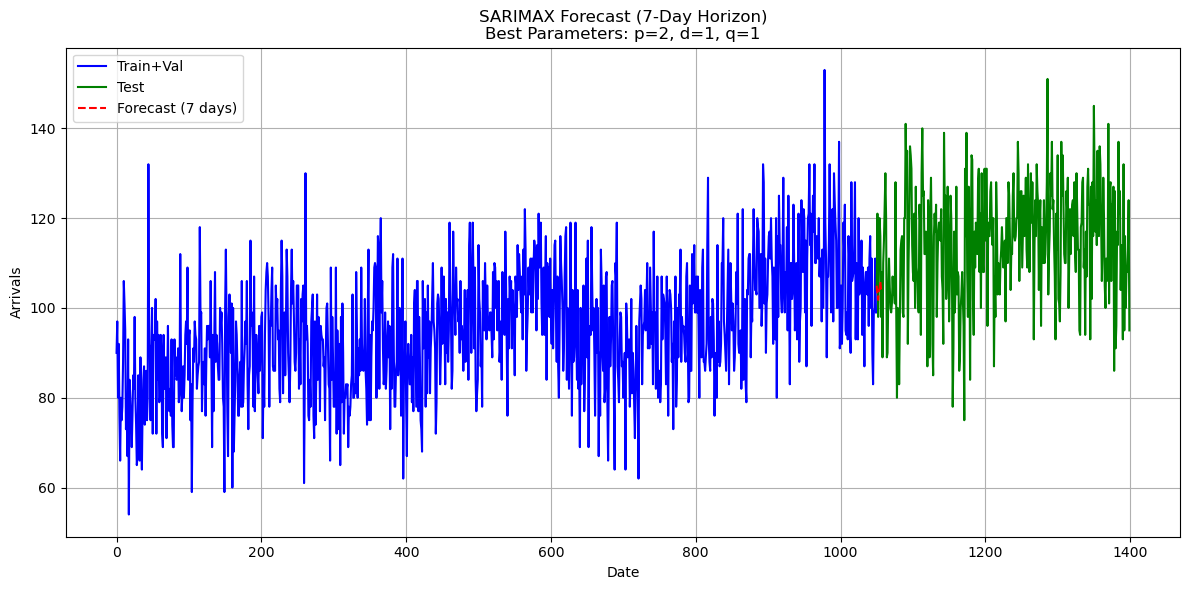

In [11]:
y = df["Arrivals"]

p_values = [0,1,2] #autoregression terms
d_values = [0,1] #number of differentiations
q_values = [0,1,2] #moving average terms

best_mape = float("inf") # so that a small mape will be kept 
best_model = None
best_params = None

y_train_val, y_test = temporal_train_test_split(y)
y_train, y_val = temporal_train_test_split(y_train_val)

fh = ForecastingHorizon(y_val.index[:7], is_relative = False)
for p in p_values:
    for d in d_values:
        for q in q_values:
            model = SARIMAX(order=(p, d, q), trend="t", seasonal_order=(1, 0, 0, 7))
            model.fit(y_train)
            y_pred = model.predict(fh = fh)

            val_subset = y_val.loc[fh.to_pandas()] #ai helped me fixed the dimensions of the val and the forecasting horizon
            #loc select a specific row from a pd series, for the days specified in the fh which has been converted into a pd datetimeindex
            mape = mean_absolute_percentage_error(val_subset, y_pred)

            if mape < best_mape:
                best_mape = mape
                best_model = model
                best_params = (p,d,q)

            print(f"Tested model with (p={p}, d={d}, q={q}) => MAPE: {mape:.2%}") #help with AI

print(f"Best model parameters: (p={best_params[0]}, d={best_params[1]}, q={best_params[2]})")
print(f"Best MAPE: {best_mape:.2%}")

final_model = SARIMAX(order=best_params, trend="t", seasonal_order=(1, 0, 0, 7))
final_model.fit(y_train_val)

fh_test = ForecastingHorizon(y_test.index[:7], is_relative=False)
y_pred_test = final_model.predict(fh=fh_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_train_val, label="Train+Val", color='blue')
plt.plot(y_test, label="Test", color='green')
plt.plot(y_pred_test, label="Forecast (7 days)", color='red', linestyle='--')
plt.title(f"SARIMAX Forecast (7-Day Horizon)\nBest Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
plt.xlabel("Date")
plt.ylabel("Arrivals")
plt.legend()
plt.grid(True)
plt.tight_layout()


5. (7 points) This question is on time series regression with K-Nearest Neighbour using the sklearn or sktime package.
* Split the time series into a train and test set. Using `GridSearchCV`, train a KNN regessor with a 5-fold cross validation. Find the best regularization (nearest neighbour) hyperparameter with 5 different neighbour values. (3 points)
* Using the best hyperparameter found from grid search on the training set, evaluate the mean absolute percentage error on the test set. (When you call grid search.fit, the best hyperparameter is automatically found and stored in grid search). (3 points)
* Display the train, validation, test set and your predicted solution. Label your plot. (1 point)

In [13]:
# 
# Your code goes here 
# 

y = df["Arrivals"]

y_train, y_test = temporal_train_test_split(y)

knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [1, 3, 5,7, 9] } 

#using gridsearch
grid_search = GridSearchCV(knn, param_grid, cv= KFold(n_splits = 5), scoring="neg_mean_squared_error")

X_train = y_train.index.factorize()[0].reshape(-1,1) #reshaping a DF into a 2d array- help from AI
#Convert the datetime index of y_train to numerical values with .factorize(), 
# which assigns an integer code for each date.
#Reshape to a 2D array because sklearn expects a 2D feature matrix X.
y_train_values = y_train.values

grid_search.fit(X_train, y_train_values)

print("Best n_neighbors:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)

X_test = y_test.index.factorize()[0].reshape(-1,1)
y_test_values = y_test.values
best_model = grid_search.best_estimator_


forecast_7_days = X_test[:7]  # Using last 7 days  for prediction
y_pred_7_days = best_model.predict(forecast_7_days)


forecast_30_days = X_test[:30]  #  last 30 days for prediction
y_pred_30_days = best_model.predict(forecast_30_days)


y_test_values_7 = y_test[:7].values
y_test_values_30 = y_test[:30].values


mape_7_days = mean_absolute_percentage_error(y_test_values_7, y_pred_7_days)
mape_30_days = mean_absolute_percentage_error(y_test_values_30, y_pred_30_days)

print(f"MAPE for 7-day forecast: {mape_7_days}")
print(f"MAPE for 30-day forecast: {mape_30_days}")


Best n_neighbors: {'n_neighbors': 9}
Best CV score (negative MSE): -165.80495002939446
MAPE for 7-day forecast: 0.2559469176810784
MAPE for 30-day forecast: 0.23302389510164057


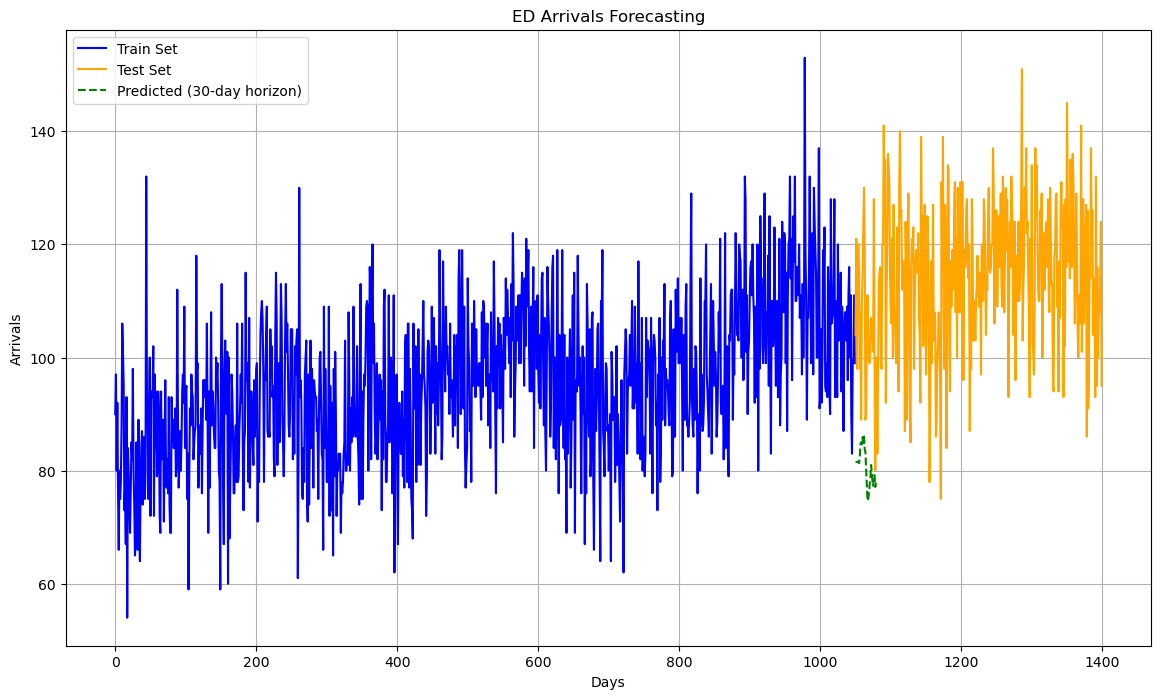

In [15]:
plt.figure(figsize=(14, 8))


plt.plot(y_train.index, y_train, label='Train Set', color='blue')
plt.plot(y_test.index, y_test, label='Test Set', color='orange')


plt.plot(y_test.index[:30], y_pred_30_days, label='Predicted (30-day horizon)', color='green', linestyle='--')

plt.title("ED Arrivals Forecasting")
plt.xlabel("Days")
plt.ylabel("Arrivals")
plt.legend()
plt.grid(True)